In [1]:
import sys
import os

parent_dir = os.path.abspath('/home/feihm/ZLspace/VGG16-pytorch-implementation/')
sys.path.append(parent_dir)

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from argparse import ArgumentParser
# from dataset import PUFDataset
from dataset_fei import PUFDataset
# from vgg16_model import VGG16_net
from vgg16_fei import VVG16_net
from transforms import *
from puf_simulator import PUFs
import random
import matplotlib.pyplot as plt
import time

### Train

In [2]:
train_transform = Compose([
                # ToPILImage(),
                ToTensor(),
            ])
test_transform = Compose([
                # ToPILImage(),
                ToTensor(),
            ])
# train_transform = None
# test_transform = None


In [3]:
epochs = 30
batch_size = 32
num_workers = 4
root = '/home/feihm/ZLspace/VGG16-pytorch-implementation/fei-test/data_shift2'
# root = '/home/feihm/ZLspace/VGG16-pytorch-implementation/fei-test/data_shift2_100_126_323'
# root = '/home/feihm/ZLspace/VGG16-pytorch-implementation/data/pattern_v2/size_100_onepuf/5_pufdata_50*50_0.1_noise_v2'
train_dataset = PUFDataset(root=root, train=True, transform=train_transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_dataset = PUFDataset(root=root, train=False, transform=test_transform)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    

In [4]:
for i in test_dataset:
    print(i[0])
    break

tensor([[[0., 1., 0.,  ..., 1., 0., 1.],
         [0., 0., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 0., 1., 1.],
         ...,
         [0., 1., 0.,  ..., 1., 1., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 假设 train_accs 和 test_accs 分别保存了每个 epoch 的训练精度和测试精度
train_accs = []  # 用于存储每个 epoch 的训练精度
test_accs = []   # 用于存储每个 epoch 的测试精度
train_confidences = []  # 用于存储每个 epoch 的训练平均置信度
test_confidences = []   # 用于存储每个 epoch 的测试平均置信度

# 使用 GPU 如果可用
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 初始化模型
model = VVG16_net(in_channels=1, n_classes=5, img_size=(128,128)).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

best_acc = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0  # 累加训练损失
    correct = 0  # 累加正确预测数
    total = 0  # 累加样本数
    total_confidence = 0.0  # 累加置信度

    # 训练阶段
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累加损失
        running_loss += loss.item()

        # 计算预测并累加正确的预测数量
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
        total_confidence += confidence.sum().item()  # 累加所有样本的置信度
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # 打印当前的迭代损失
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))

    # 计算并打印训练精度和平均损失
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    avg_train_confidence = total_confidence / total  # 计算训练阶段的平均置信度
    print('Epoch: {}/{} Training Loss: {:.4f} Training Acc: {:.4f} Avg Train Confidence: {:.4f}'.format(epoch+1, epochs, train_loss, train_acc, avg_train_confidence))
    
    train_accs.append(train_acc)
    train_confidences.append(avg_train_confidence)

    # 测试阶段
    model.eval()
    all_predictions = []
    all_labels = []
    test_loss = 0.0
    total_confidence = 0.0  # 重置测试置信度累加

    with torch.no_grad():
        for iter, (images, labels) in enumerate(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 累加测试损失
            test_loss += loss.item()

            # 收集预测和标签
            probs = F.softmax(outputs, dim=1)
            confidence, predictions = torch.max(probs, 1)
            total_confidence += confidence.sum().item()  # 累加所有样本的置信度
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算并打印测试精度和平均损失
    acc = accuracy_score(all_labels, all_predictions)
    test_loss = test_loss / len(test_dataloader)
    avg_test_confidence = total_confidence / len(all_labels)  # 计算测试阶段的平均置信度
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f} Avg Test Confidence: {:.4f}'.format(epoch+1, epochs, test_loss, acc, avg_test_confidence))
    
    test_accs.append(acc)
    test_confidences.append(avg_test_confidence)

    # 保存模型
    torch.save(model.state_dict(), 'model/last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'model/best.pt')
        best_acc = acc


conv_output_size: 18432


Epoch: 1/30 Iter: 9 Loss: 1.6799: 100%|██████████| 9/9 [00:01<00:00,  8.34it/s]

Epoch: 1/30 Training Loss: 1.6500 Training Acc: 0.1667 Avg Train Confidence: 0.2570


Epoch: 1/30 Test Loss: 1.6105 Test Acc: 0.2000 Avg Test Confidence: 0.2039


Epoch: 2/30 Iter: 9 Loss: 1.5939: 100%|██████████| 9/9 [00:00<00:00, 14.43it/s]

Epoch: 2/30 Training Loss: 1.6318 Training Acc: 0.2188 Avg Train Confidence: 0.2746


Epoch: 2/30 Test Loss: 1.6081 Test Acc: 0.2400 Avg Test Confidence: 0.2024


Epoch: 3/30 Iter: 9 Loss: 1.6683: 100%|██████████| 9/9 [00:00<00:00, 12.14it/s]

Epoch: 3/30 Training Loss: 1.5833 Training Acc: 0.2500 Avg Train Confidence: 0.2893


Epoch: 3/30 Test Loss: 1.6158 Test Acc: 0.2650 Avg Test Confidence: 0.2210


Epoch: 4/30 Iter: 9 Loss: 1.4929: 100%|██████████| 9/9 [00:00<00:00, 14.43it/s]

Epoch: 4/30 Training Loss: 1.5568 Training Acc: 0.3194 Avg Train Confidence: 0.3132


Epoch: 4/30 Test Loss: 1.5839 Test Acc: 0.3050 Avg Test Confidence: 0.2186


Epoch: 5/30 Iter: 9 Loss: 1.2679: 100%|██████████| 9/9 [00:00<00:00, 14.67it/s]

Epoch: 5/30 Training Loss: 1.3880 Training Acc: 0.4028 Avg Train Confidence: 0.3322


Epoch: 5/30 Test Loss: 1.3529 Test Acc: 0.6000 Avg Test Confidence: 0.3396


Epoch: 6/30 Iter: 9 Loss: 1.0198: 100%|██████████| 9/9 [00:00<00:00, 14.04it/s]


Epoch: 6/30 Training Loss: 1.1776 Training Acc: 0.5278 Avg Train Confidence: 0.4577
Epoch: 6/30 Test Loss: 1.2859 Test Acc: 0.4200 Avg Test Confidence: 0.5816


Epoch: 7/30 Iter: 9 Loss: 0.8457: 100%|██████████| 9/9 [00:00<00:00, 14.43it/s]

Epoch: 7/30 Training Loss: 0.8968 Training Acc: 0.5903 Avg Train Confidence: 0.5572


Epoch: 7/30 Test Loss: 2.5898 Test Acc: 0.4000 Avg Test Confidence: 0.9055


Epoch: 8/30 Iter: 9 Loss: 0.5765: 100%|██████████| 9/9 [00:00<00:00, 15.52it/s]

Epoch: 8/30 Training Loss: 0.7514 Training Acc: 0.6632 Avg Train Confidence: 0.6080


Epoch: 8/30 Test Loss: 0.6773 Test Acc: 0.7550 Avg Test Confidence: 0.6366


Epoch: 9/30 Iter: 6 Loss: 0.6112:  67%|██████▋   | 6/9 [00:00<00:00, 16.65it/s]

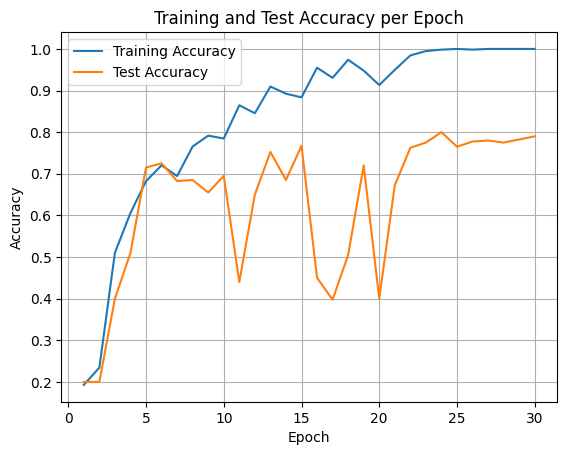

In [7]:
def plot_accuracy(train_accs, test_accs):
    epochs = range(1, len(train_accs) + 1)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.title('Training and Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_accuracy(train_accs, test_accs)

In [14]:
# def bool_to_uint8(image):
#     return image.astype(np.uint8) * 255

# train_transform = Compose([
#                 lambda x: bool_to_uint8(x),  # 将bool类型转换为uint8类型
#                 ToPILImage(),                # 转换为PIL图像
#                 ToTensor(),                  # 转换为Tensor
#                 lambda x: (x > 0.5).float()  # 将Tensor转换为0或1
#             ])

# test_transform = Compose([
#                 lambda x: bool_to_uint8(x),  # 将bool类型转换为uint8类型
#                 ToPILImage(),                # 转换为PIL图像
#                 ToTensor(),                  # 转换为Tensor
#                 lambda x: (x > 0.5).float()  # 将Tensor转换为0或1
#             ])